In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import weibull_min
from scipy.linalg import toeplitz, solve

# Utility functions

## Survival curves and toeplitz


In [2]:
def weibull_sf(n, shape=5, loc=0, scale=20):
    """Compute the survival function (SF) of the Weibull distribution.

    Args:
        n: The number of integers to evaluate the SF at.
        shape: determine the skewness of the distribution
            (shape < 1 = skewed to the right, shape>1 = skewed to the left)
        loc: determine the minimum value that the distribution can take)
        scale: determine the spread of the distribution (scale = shift along x-axis)

    Returns:
        An array of the survival function (SF) values of the Weibull distribution
        evaluated at integers from 0 to n-1.
    """
    x = np.arange(n)
    return weibull_min.sf(x, c=shape, loc=loc, scale=scale)


def compute_survival_curve(kind, n, **kwargs):
    """Compute the survival function (SF) for a given statistical distribution

    Args:
        kind: The kind of distribution to use. Current options are: [weibull]
        n: The number of integers to evaluate the SF at.
        **kwargs: Additional distribution-specific parameters.

    Returns:
        An array of the survival function (SF) values of the specified distribution
        evaluated at integers from 0 to n-1.
    """
    survival_function = {"weibull": weibull_sf}
    return survival_function[kind](n, **kwargs)


def compute_toeplitz_sf(arr):
    """Compute the (lower triangle) Toeplitz matrix of a survival curve.

    Args:
        arr: An array representing the survival curve.

    Returns:
        The Toeplitz matrix of the survival curve
    """
    n = len(arr)
    return toeplitz(arr) * np.tril(np.ones(shape=(n, n)))


def convert_to_df(time, survival_curve, cohort, inflow, outflow, stock, nas):
    """Convert the different (numpy) arrays representing a stock-flow model into DataFrames.

    Args:
        time: the time axis of the model.
        survival_curve: the survival curve used for the model.
        cohort: the cohort data of the model.
        inflow: the inflow data of the model.
        outflow: the outflow data of the model.
        stock: the stock data of the model.
        nas: The net addition to stock data of the model.

    Returns:
        A tuple containing two Pandas DataFrames:
        `timeseries` representing 5 vectors (survival curve, inflow, outflow, nas and stock)
            with time as index
        `cohort` matrix (time as both index and columns)
    """
    timeseries = pd.DataFrame(
        data={
            "survival_curve": survival_curve,
            "inflow": inflow,
            "outflow": outflow,
            "stock": stock,
            "nas": nas,
        },
        index=time,
    )
    cohort = pd.DataFrame(cohort, index=time, columns=time)
    return timeseries, cohort


## Stock Flow Model


In [3]:
def flow_driven_model(time, inflow, sf_kind="weibull", stock_ini=0, **kwargs):
    """Computes a stock-flow model given inflow

    Args:
        time (np.ndarray): 1D array of time values
        inflow (np.ndarray): 1D array of inflow values
        sf_kind (str): Type of survival function used to compute the survival curve (default 'weibull').
            Valid options are ['weibull']
        stock_ini (float): Initial stock value (default 0)
        **kwargs: Additional keyword arguments for the selected survival function

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: A tuple containing two pandas DataFrames - timeseries and cohort.
        timeseries: A pandas DataFrame containing columns [survival_curve, inflow, outflow, stock, nas]
            and index as the given time array
        cohort: A pandas DataFrame representing the cohort table, with rows and columns indexed by time.
            The values represent the number of individuals in the cohort at each time point.

    Raises:
        ValueError: If sf_kind is not a valid option
    """
    survival_curve = compute_survival_curve(kind=sf_kind, n=len(time), **kwargs)
    survival_toeplitz = compute_toeplitz_sf(survival_curve)
    cohort = inflow * survival_toeplitz
    stock = cohort.sum(axis=1)  # EXTRA STEP COMPARED WITH STOCK-DRIVEN
    nas = np.diff(stock, prepend=stock_ini)
    outflow = inflow - nas
    timeseries, cohort = convert_to_df(
        time, survival_curve, cohort, inflow, outflow, stock, nas
    )
    return timeseries, cohort


def stock_driven_model(time, stock, sf_kind="weibull", stock_ini=0, **kwargs):
    """Computes a stock-flow model given stocks

    Args:
        time (np.ndarray): 1D array of time values
        stock (np.ndarray): 1D array of stock values
        sf_kind (str): Type of survival function used to compute the survival curve (default 'weibull').
            Valid options are ['weibull']
        stock_ini (float): Initial stock value (default 0)
        **kwargs: Additional keyword arguments for the selected survival function

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: A tuple containing two pandas DataFrames:
        - timeseries: A pandas DataFrame containing columns [survival_curve, inflow, outflow, stock, nas]
            and index as the given time array
        - cohort: A pandas DataFrame representing the cohort table, with rows and columns indexed by time.
            The values represent the number of individuals in the cohort at each time point.

    Raises:
        ValueError: If sf_kind is not a valid option
    """
    survival_curve = compute_survival_curve(kind=sf_kind, n=len(time), **kwargs)
    survival_toeplitz = compute_toeplitz_sf(survival_curve)
    inflow = solve(survival_toeplitz, stock)  # EXTRA STEP COMPARED WITH FLOW-DRIVEN
    cohort = inflow * survival_toeplitz
    nas = np.diff(stock, prepend=stock_ini)
    outflow = inflow - nas
    timeseries, cohort = convert_to_df(
        time, survival_curve, cohort, inflow, outflow, stock, nas
    )
    return timeseries, cohort


# Scenario analysis

## Data import


In [4]:
FILE_PATH = "../../data/vehicles.xlsx"
data = pd.read_excel(FILE_PATH, sheet_name=None)

# Stock data
year = data["stocks"]["year"].values
stock = data["stocks"]["vehicle_stock"].values

# Survival curve parameters
shape = 2.428914875
scale = 16.93851375


## Baseline scenario

### EV stocks and flows


Axes(0.125,0.11;0.775x0.77)
Axes(0.125,0.11;0.775x0.77)
Axes(0.125,0.11;0.775x0.77)


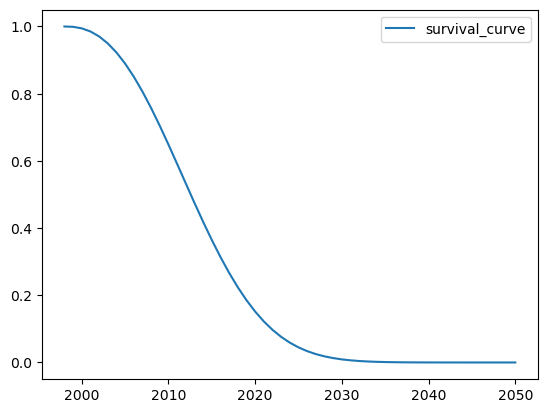

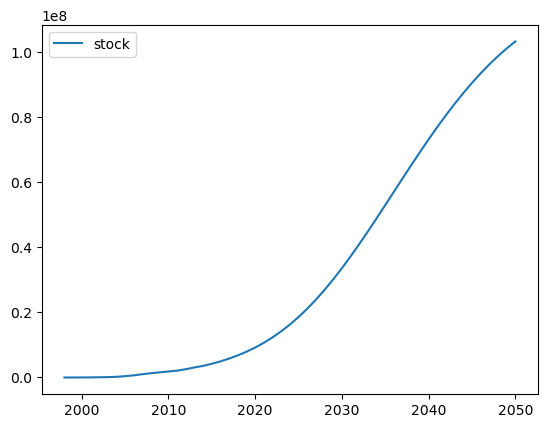

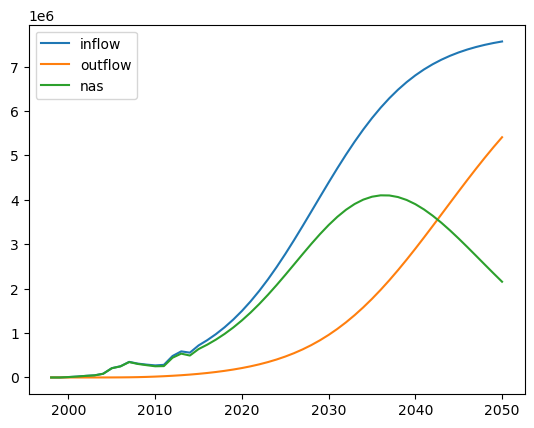

In [5]:
timeseries_EV_baseline, cohort_EV_baseline = stock_driven_model(
    time=year, stock=stock, sf_kind="weibull", shape=shape, scale=scale
)

# Display survival curve, flows and stocks
print(timeseries_EV_baseline.plot(y="survival_curve"))
print(timeseries_EV_baseline.plot(y="stock"))
print(timeseries_EV_baseline.plot(y=["inflow", "outflow", "nas"]))

<Axes: >

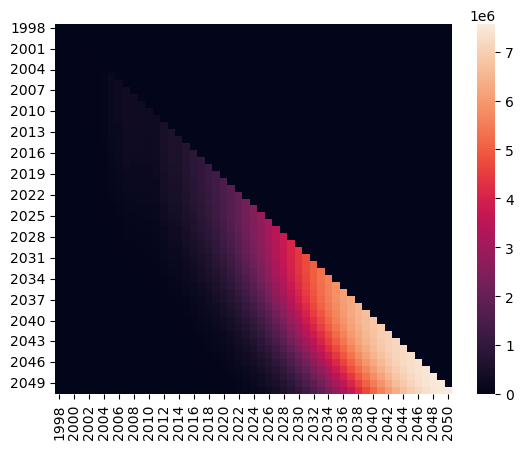

In [6]:
# Display cohorts
sns.heatmap(cohort_EV_baseline, annot=False)


<Axes: >

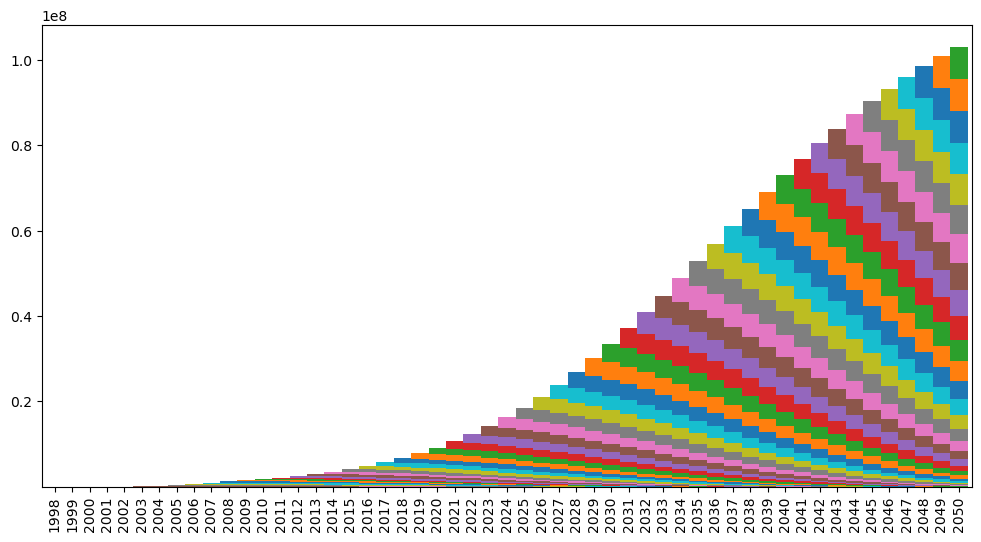

In [7]:
# Display stocks by cohort
cohort_EV_baseline.plot(
    kind="bar", stacked=True, legend=False, width=1, figsize=(12, 6)
)


### Steel and Aluminium stocks and flows


In [8]:
# intensity in grams/car
EV = "HEV_NiMH"
material_intensities = data["material_intensities"][EV].set_axis(
    data["material_intensities"]["grams/car"]
)

# Steel (Iron) & Aluminium stock
timeseries_baseline = dict()
cohort_baseline = dict()

for element in ["Fe", "Al"]:
    element_intensity = material_intensities[element]
    element_inflow = element_intensity * timeseries_EV_baseline["inflow"]
    timeseries_baseline[element], cohort_baseline[element] = flow_driven_model(
        time=year,
        inflow=element_inflow.values,
        sf_kind="weibull",
        shape=shape,
        scale=scale,
    )


## Material substitution

A new aluminum-cerium alloy (Sims et al., 2022) becomes available in 2025 that can replace steel in multiple applications in vehicles. Hybrid vehicles with the new alloy have these MIs (in grams/car):


In [9]:
# new intensity in grams/car
new_material_intensities = {"Fe": 911804.25, "Al": 154073.40}


### Scenario 1: immediate replacement

The new alloy is extremely successful, and all vehicles sold from 2025 have the new material intensities


In [10]:
# Compute market share of each alloy
market_share = pd.DataFrame(
    data={"old_alloy": 0, "new_alloy": 0},
    index=year,
)

market_share.loc[market_share.index >= 2025, "new_alloy"] = 1
market_share["old_alloy"] = 1 - market_share["new_alloy"]


In [11]:
timeseries_scenario_1 = dict()
cohort_scenario_1 = dict()

for element in ["Fe", "Al"]:
    # compute average material intensity
    avg_material_intensity = (
        market_share["old_alloy"] * material_intensities[element]
        + market_share["new_alloy"] * new_material_intensities[element]
    )
    # compute element inflow (in grams)
    element_inflow = avg_material_intensity * timeseries_EV_baseline["inflow"]
    # compute element stock
    timeseries_scenario_1[element], cohort_scenario_1[element] = flow_driven_model(
        time=year,
        inflow=element_inflow.values,
        sf_kind="weibull",
        shape=shape,
        scale=scale,
    )

### Scenario 2: gradual replacement

The new alloy is gradually introduced to the market. in 2025, 1% of new cars have the new MIs, growing linearly to 50% of new cars sold in 2050. The rest have the original MIs.


In [12]:
market_share = pd.DataFrame(
    data={"old_alloy": 0, "new_alloy": 0},
    index=year,
)

market_share.loc[market_share.index >= 2025, "new_alloy"] = np.linspace(0.01, 0.5, 26)
market_share["old_alloy"] = 1 - market_share["new_alloy"]


In [13]:
timeseries_scenario_2 = dict()
cohort_scenario_2 = dict()

for element in ["Fe", "Al"]:
    # compute average material intensity
    avg_material_intensity = (
        market_share["old_alloy"] * material_intensities[element]
        + market_share["new_alloy"] * new_material_intensities[element]
    )
    # compute element inflow (in grams)
    element_inflow = avg_material_intensity * timeseries_EV_baseline["inflow"]
    # compute element stock
    timeseries_scenario_2[element], cohort_scenario_2[element] = flow_driven_model(
        time=year,
        inflow=element_inflow.values,
        sf_kind="weibull",
        shape=shape,
        scale=scale,
    )


### Scenario comparison


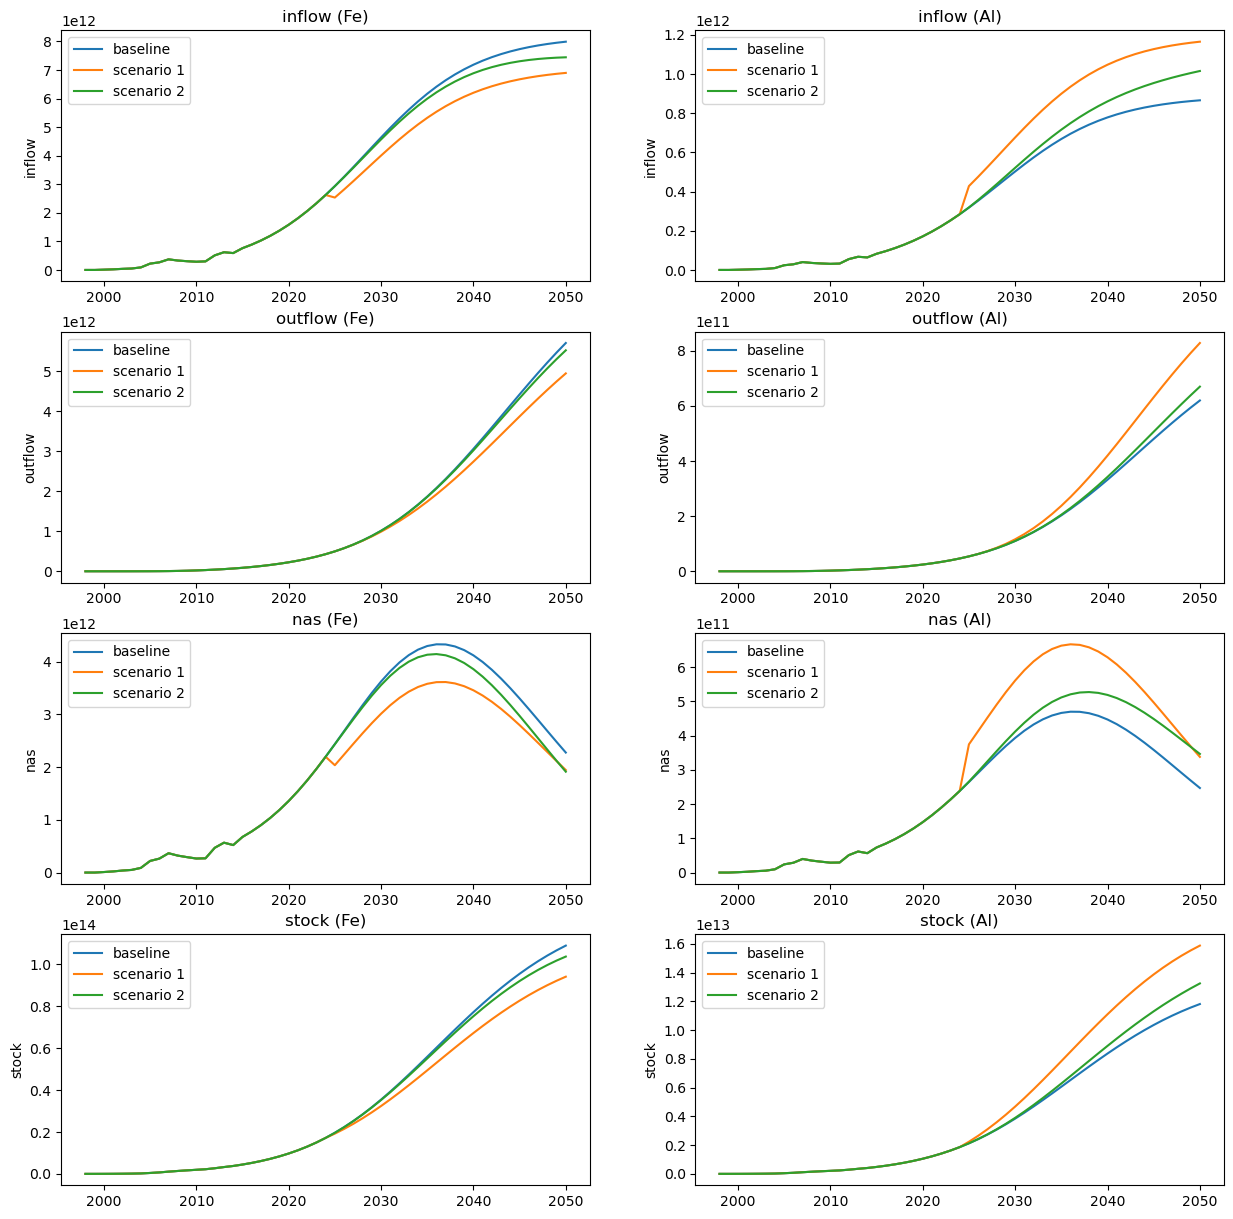

In [15]:
fig, ax = plt.subplots(4, 2, figsize=(15, 15), sharey=False)

for j, element in enumerate(["Fe", "Al"]):
    for i, column in enumerate(["inflow", "outflow", "nas", "stock"]):
        sns.lineplot(
            data=timeseries_baseline[element][column], ax=ax[i, j], label="baseline"
        )
        sns.lineplot(
            data=timeseries_scenario_1[element][column], ax=ax[i, j], label="scenario 1"
        )
        sns.lineplot(
            data=timeseries_scenario_2[element][column], ax=ax[i, j], label="scenario 2"
        )
        ax[i, j].set_title(f"{column} ({element})")